<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#fasttext-models" data-toc-modified-id="fasttext-models-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>fasttext models</a></span></li><li><span><a href="#networks" data-toc-modified-id="networks-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>networks</a></span></li></ul></div>

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import os
import numpy as np
import pandas as pd
import pickle

from gensim.models.fasttext import FastText
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Embedding, Input, Concatenate, Reshape, LSTM, GRU
from keras.optimizers import Adam
from keras.preprocessing.text import text_to_word_sequence

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic

from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt

%matplotlib inline

# fasttext models

In [6]:
df_chats_raw = pd.read_csv('../data/clean_text.csv')

In [7]:
class SentenceIterator(object):
    texts = None

    def __init__(self, texts):
        self.texts = texts

    def __iter__(self):
        for text in self.texts:
            yield text_to_word_sequence(text, lower=False)

In [8]:
def build_fasttext(size=100):
    path = '../data/fasttext_chats_%d.pkl' % size
    if os.path.exists(path):
        m = FastText.load(path)
    else:
        m = FastText(SentenceIterator(df_chats_raw['clean_text']), min_count=5, size=size, workers=-1)
        m.save(path)
    return m

In [9]:
def text2vec(text, m=None, size=None):
    vectors = []
    for word in text_to_word_sequence(text):
        try:
            v = m.wv[word]
            vectors.append(v)
        except Exception as e:
            pass
    if not vectors:
        return np.zeros((size, ))
    return sum(vectors) / len(vectors)

In [10]:
def build_vectors(texts, size=None):
    t_model = build_fasttext(size)
    vectors = list(map(lambda x: text2vec(x, m=t_model, size=size), texts))
    return np.array(vectors)

# networks

In [11]:
TICKER = 'ETH'

In [12]:
df_prices_raw = pd.read_csv('../data/train/tickers_train.csv', index_col=0)

In [13]:
df_prices_raw['timestamp'] = pd.to_datetime(df_prices_raw['datetime']).apply(lambda x: x.timestamp())

In [14]:
df_prices = df_prices_raw[df_prices_raw['ticker'] == TICKER].copy()

In [15]:
df_chats = df_chats_raw[df_chats_raw['clean_text'].str.contains(TICKER.lower())].copy()

In [16]:
chat_ids = list(df_chats['chat_id'].unique())
chat_ids.sort()
chat2ind = {chat_id: i for i, chat_id in enumerate(chat_ids)}

sender_ids = list(df_chats['sender_id'].unique())
sender_ids.sort()
sender2ind = {sender_id: i for i, sender_id in enumerate(sender_ids)}

In [17]:
df_chats['chat_ind'] = df_chats['chat_id'].apply(lambda x: chat2ind[x])
df_chats['sender_ind'] = df_chats['sender_id'].apply(lambda x: sender2ind[x])

In [18]:
df_chats['ind'] = list(range(df_chats.shape[0]))

In [19]:
vectors100 = build_vectors(df_chats['clean_text'], size=100)

In [20]:
vectors160 = build_vectors(df_chats['clean_text'], size=160)

In [21]:
vectors60 = build_vectors(df_chats['clean_text'], size=60)

In [37]:
def build_dataset(samples=5, steps=32, vectors=None):
    
    target_min_up=1.1
    target_max_down=0.95
    hours_before=48
    hours_after=48
    
    np.random.seed(0)
    
    inp_fasttext = []
    inp_chat_ind = []
    inp_sender_ind = []
    inp_timedelta_log = []
    out_target = [] # grow more than 0.66 quantile, not drawdown less 0.33 quantile in period 48 hours
    
    for i, row in df_prices.iterrows():
        for sample in range(samples):
            ts = row['timestamp']

            df_chats_sample = df_chats[
                (df_chats['timestamp'] > ts - hours_before * 3600) & 
                (df_chats['timestamp'] < ts)].sample(steps, replace=True)
            df_chats_sample['timedelta'] = np.log(-(df_chats_sample['timestamp'] - ts))

            chat_indexes = df_chats_sample['ind'].values

            batch_fasttext = vectors[chat_indexes]
            batch_chat_ind = df_chats.iloc[chat_indexes]['chat_ind'].values
            batch_sender_ind = df_chats.iloc[chat_indexes]['sender_ind'].values
            batch_timedelta = df_chats_sample['timedelta'].values

            df_prices_forward = df_prices[
                (df_prices['timestamp'] > ts) & 
                (df_prices['timestamp'] <= ts + hours_after * 3600)].copy()
            df_prices_forward = df_prices_forward.sort_values('timestamp')

            if df_prices_forward.shape[0] < int(hours_after / 2):
                continue
            df_prices_forward['priceUsd'] /= df_prices_forward['priceUsd'].values[0]

            target = False
            for price_relative in df_prices_forward['priceUsd'].values:
                if price_relative < target_max_down:
                    target = False
                    break
                if price_relative > target_min_up:
                    target = True
                    break

            inp_fasttext.append(batch_fasttext)
            inp_chat_ind.append(batch_chat_ind)
            inp_sender_ind.append(batch_sender_ind)
            inp_timedelta_log.append(batch_timedelta)
            out_target.append(target)
    
    inp_fasttext = np.array(inp_fasttext)
    inp_chat_ind = np.array(inp_chat_ind)
    inp_sender_ind = np.array(inp_sender_ind)
    inp_timedelta_log = np.array(inp_timedelta_log)

    out_target = np.array(out_target)
    
    inp_chat_ind = np.expand_dims(inp_chat_ind, 2)
    inp_sender_ind = np.expand_dims(inp_sender_ind, 2)
    inp_timedelta_log = np.expand_dims(inp_timedelta_log, 2)

    test_size = int(inp_fasttext.shape[0] * 0.1)
    
    X_train = [
        inp_fasttext[:-test_size], inp_chat_ind[:-test_size], 
        inp_sender_ind[:-test_size], inp_timedelta_log[:-test_size]]
    Y_train = out_target[:-test_size]
    validation_data=[
        [inp_fasttext[-test_size:], inp_chat_ind[-test_size:], inp_sender_ind[-test_size:], inp_timedelta_log[-test_size:]],
        out_target[-test_size:]
    ]
    
    return X_train, Y_train, validation_data

In [27]:
def build_nn(sender_size=128, chat_size=4, STEPS=None, lr=0.0001, fasttext_size=100):

    SENDER_EMBEDDING_SIZE = sender_size
    CHAT_EMBEDDING_SIZE = chat_size

    inp_layer_fasttext = Input(shape=(STEPS, fasttext_size, ), name='inp_layer_fasttext')
    # inp_layer_sender_bot = Input(shape=(STEPS, 1, ), name='inp_layer_sender_bot')
    inp_layer_chat = Input(shape=(STEPS, 1, ), name='inp_layer_chat')
    inp_layer_sender = Input(shape=(STEPS, 1, ), name='inp_layer_sender')
    inp_layer_timedelta = Input(shape=(STEPS, 1, ), name='inp_layer_timedelta')

    sender_embedding = Embedding(len(sender2ind), SENDER_EMBEDDING_SIZE)(inp_layer_sender)
    chat_embedding = Embedding(len(chat2ind), CHAT_EMBEDDING_SIZE)(inp_layer_chat)

    sender_embedding = Reshape((STEPS, SENDER_EMBEDDING_SIZE))(sender_embedding)
    chat_embedding = Reshape((STEPS, CHAT_EMBEDDING_SIZE))(chat_embedding)

    common_layer = Concatenate(axis=-1)([
        inp_layer_fasttext, chat_embedding, sender_embedding, inp_layer_timedelta])

    lstm = LSTM(8)(common_layer)
    # lstm = LSTM(8)(lstm)

    dense = Dense(1, activation='sigmoid')(lstm)

    model = Model(
        inputs=[inp_layer_fasttext, inp_layer_chat, inp_layer_sender, inp_layer_timedelta],
        outputs=dense
    )

    opt = Adam(lr=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model
# model.compile(optimizer='sgd', loss='binary_crossentropy')

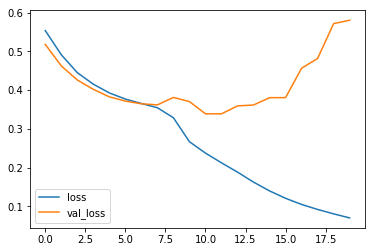

CPU times: user 2min 52s, sys: 46.8 s, total: 3min 39s
Wall time: 50.6 s


In [74]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=128, chat_size=4, STEPS=32, lr=0.0001, fasttext_size=100)
X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=vectors100)
model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

y_pred = model.predict(val1[0])
roc_auc_score(val1[1], y_pred)

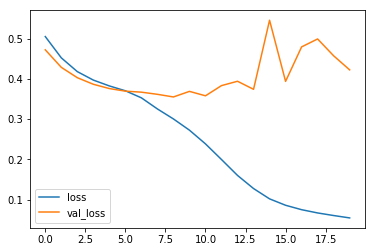

CPU times: user 2min 57s, sys: 48.1 s, total: 3min 45s
Wall time: 52.8 s


In [75]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=128, chat_size=4, STEPS=32, lr=0.0001, fasttext_size=160)
X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=vectors160)
model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

y_pred = model.predict(val1[0])
roc_auc_score(val1[1], y_pred)

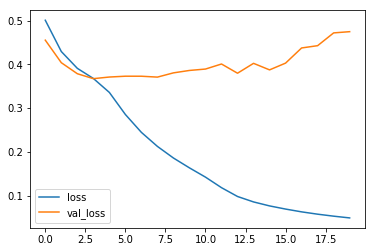

CPU times: user 3min 12s, sys: 49.1 s, total: 4min 1s
Wall time: 53.1 s


In [76]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=128, chat_size=4, STEPS=32, lr=0.0001, fasttext_size=260)
X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=np.concatenate([vectors100, vectors160], axis=1))
model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

y_pred = model.predict(val1[0])
roc_auc_score(val1[1], y_pred)

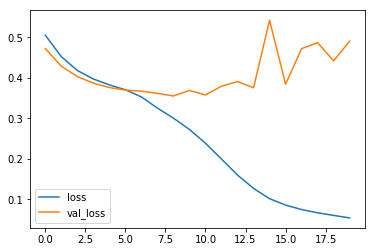

CPU times: user 3min 1s, sys: 46 s, total: 3min 47s
Wall time: 52 s


In [77]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=128, chat_size=4, STEPS=32, lr=0.0001, fasttext_size=160)
X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=np.concatenate([vectors100, vectors60], axis=1))
model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

y_pred = model.predict(val1[0])
roc_auc_score(val1[1], y_pred)

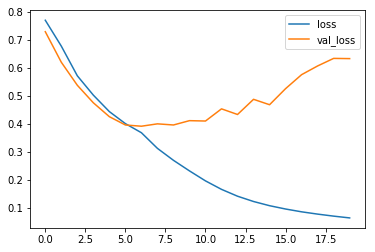

CPU times: user 2min 47s, sys: 46.3 s, total: 3min 34s
Wall time: 50.2 s


In [78]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=128, chat_size=4, STEPS=32, lr=0.0001, fasttext_size=60)
X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=vectors60)
model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

y_pred = model.predict(val1[0])
roc_auc_score(val1[1], y_pred)

In [82]:
with open('../data/train_test.pkl', 'wb') as f:
    f.write(pickle.dumps({
        'x': X1,
        'y': Y1,
        'validation': val1,
    }))

# tune hyperparams

In [29]:
space = {
    'sender_size': hp.choice('sender_size', list(range(8, 256))),
    'chat_size': hp.choice('chat_size', list(range(2, 10))),
    'steps': hp.choice('steps', [32, 64, 128]),
    'lr': 10**hp.uniform('lr', -8, -2),
    'samples': hp.choice('samples', list(range(1, 10))),
}

In [30]:
x = hyperopt.pyll.stochastic.sample(space)

In [31]:
x

{'chat_size': 2,
 'lr': 0.0016457644842810236,
 'samples': 1,
 'sender_size': 114,
 'steps': 128}

In [32]:
del x

In [53]:
def objective(x):
    
    np.random.seed(0)
    
    print(x)
    
    model = build_nn(
        sender_size=x['sender_size'], chat_size=x['chat_size'], STEPS=x['steps'], 
        lr=x['lr'], fasttext_size=100)
    X1, Y1, val1 = build_dataset(samples=x['samples'], steps=x['steps'], vectors=vectors100)
    model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)
    
    y_pred = model.predict(val1[0])
    score = roc_auc_score(val1[1], y_pred)
    
    print('roc_auc', score)
    
    return {'loss': -score, 'status': STATUS_OK}

In [54]:
trials = Trials()

In [55]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=20, trials=trials)

{'chat_size': 7, 'lr': 0.006918750043673687, 'samples': 8, 'sender_size': 198, 'steps': 128}
roc_auc 0.6615463389656937
{'chat_size': 5, 'lr': 9.995474354714894e-07, 'samples': 6, 'sender_size': 80, 'steps': 32}
roc_auc 0.5905797101449276
{'chat_size': 8, 'lr': 1.1455768949709289e-08, 'samples': 3, 'sender_size': 28, 'steps': 32}
roc_auc 0.49666436622958365
{'chat_size': 7, 'lr': 0.007455494149785534, 'samples': 5, 'sender_size': 78, 'steps': 128}
roc_auc 0.6386650386650388
{'chat_size': 2, 'lr': 3.632134753241807e-06, 'samples': 3, 'sender_size': 172, 'steps': 128}
roc_auc 0.49689440993788825
{'chat_size': 8, 'lr': 4.970548031870346e-06, 'samples': 4, 'sender_size': 217, 'steps': 32}
roc_auc 0.5555555555555556
{'chat_size': 3, 'lr': 1.892660765248683e-06, 'samples': 6, 'sender_size': 229, 'steps': 128}
roc_auc 0.4702093397745571
{'chat_size': 5, 'lr': 7.460944658023947e-05, 'samples': 6, 'sender_size': 189, 'steps': 64}
roc_auc 0.6499884978145848
{'chat_size': 4, 'lr': 3.0370119356449

In [56]:
best

{'chat_size': 3,
 'lr': -4.478658345494257,
 'samples': 4,
 'sender_size': 205,
 'steps': 2}

In [59]:
{'chat_size': 5, 'lr': 0.000033215565785761354, 'samples': 5, 'sender_size': 213, 'steps': 128}
# roc_auc 0.7789987789987789

{'chat_size': 5,
 'lr': 3.3215565785761354e-05,
 'samples': 5,
 'sender_size': 213,
 'steps': 128}

Train on 3186 samples, validate on 354 samples
Epoch 1/20
3186/3186 [==============================] - 10s 3ms/step - loss: 0.4798 - acc: 0.8836 - val_loss: 0.4677 - val_acc: 0.8898
Epoch 2/20
3186/3186 [==============================] - 6s 2ms/step - loss: 0.4640 - acc: 0.8836 - val_loss: 0.4525 - val_acc: 0.8898
Epoch 3/20
3186/3186 [==============================] - 6s 2ms/step - loss: 0.4483 - acc: 0.8836 - val_loss: 0.4384 - val_acc: 0.8898
Epoch 4/20
3186/3186 [==============================] - 6s 2ms/step - loss: 0.4343 - acc: 0.8836 - val_loss: 0.4265 - val_acc: 0.8898
Epoch 5/20
3186/3186 [==============================] - 6s 2ms/step - loss: 0.4226 - acc: 0.8836 - val_loss: 0.4166 - val_acc: 0.8898
Epoch 6/20
3186/3186 [==============================] - 6s 2ms/step - loss: 0.4125 - acc: 0.8836 - val_loss: 0.4079 - val_acc: 0.8898
Epoch 7/20
3186/3186 [==============================] - 6s 2ms/step - loss: 0.4038 - acc: 0.8836 - val_loss: 0.4004 - val_acc: 0.8898
Epoch 8/20
318

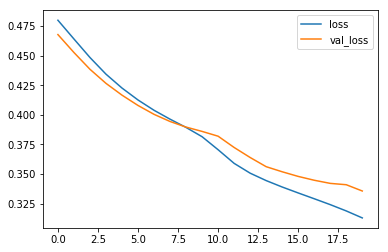

roc auc 0.7917785917785917
CPU times: user 10min 1s, sys: 1min 44s, total: 11min 46s
Wall time: 2min 22s


In [64]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=213, chat_size=5, STEPS=128, lr=0.00003, fasttext_size=100)
X1, Y1, val1 = build_dataset(samples=5, steps=128, vectors=vectors100)
model.fit(X1, Y1, validation_data=val1, epochs=20)

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

y_pred = model.predict(val1[0])
score = roc_auc_score(val1[1], y_pred)

print('roc auc', score)

[]

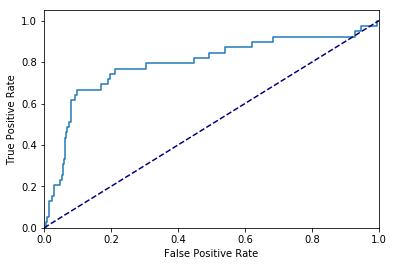

In [116]:
fpr, tpr, thresholds = roc_curve(val1[1], y_pred)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot()

In [117]:
X2, Y2, val2 = build_dataset(samples=1, steps=128, vectors=vectors100)
y2_pred = model.predict(val2[0])[:, 0]

In [121]:
for fp, tp, th in zip(fpr, tpr, thresholds):
    if tp > 0.6:
        print(th)
        break

0.23591049


In [126]:
(y2_pred > th).astype(np.int).shape

(70,)

In [127]:
(y2_pred > th).astype(np.int)

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [125]:
model.save('../data/model_eth.pkl')

# visualizations

In [23]:
model = load_model('../data/model_eth.pkl')

In [27]:
e = model.layers[3]

In [28]:
weights = e.get_weights()[0]

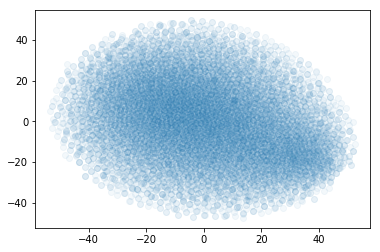

In [94]:
%%time
tsne = TSNE()
weights_tsne = tsne.fit_transform(weights)
plt.scatter(weights_tsne[:, 0], weights_tsne[:, 1], alpha=0.05)
plt.show()

In [30]:
TSNE?

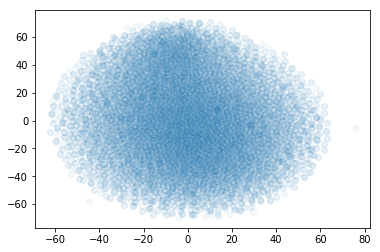

CPU times: user 3min 20s, sys: 18 s, total: 3min 38s
Wall time: 3min 38s


In [31]:
%%time
tsne = TSNE(perplexity=20.)
weights_tsne = tsne.fit_transform(weights)
plt.scatter(weights_tsne[:, 0], weights_tsne[:, 1], alpha=0.05)
plt.show()

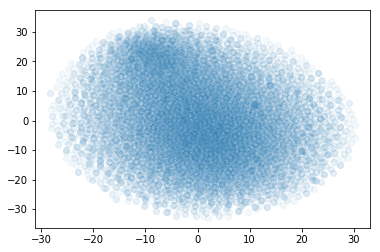

CPU times: user 3min 11s, sys: 19.4 s, total: 3min 30s
Wall time: 3min 30s


In [32]:
%%time
tsne = TSNE(perplexity=40.)
weights_tsne = tsne.fit_transform(weights)
plt.scatter(weights_tsne[:, 0], weights_tsne[:, 1], alpha=0.05)
plt.show()

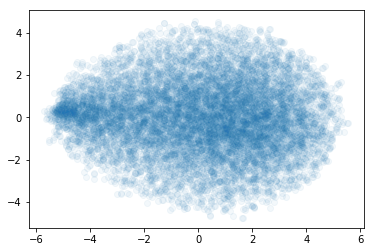

CPU times: user 4min 19s, sys: 19.4 s, total: 4min 38s
Wall time: 4min 38s


In [33]:
%%time
tsne = TSNE(perplexity=60.)
weights_tsne = tsne.fit_transform(weights)
plt.scatter(weights_tsne[:, 0], weights_tsne[:, 1], alpha=0.05)
plt.show()

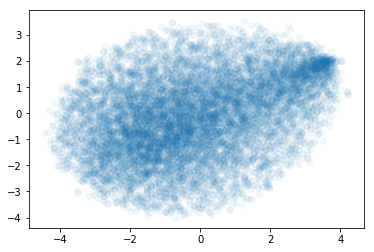

CPU times: user 4min 43s, sys: 19.6 s, total: 5min 2s
Wall time: 5min 2s


In [34]:
%%time
tsne = TSNE(perplexity=80.)
weights_tsne = tsne.fit_transform(weights)
plt.scatter(weights_tsne[:, 0], weights_tsne[:, 1], alpha=0.05)
plt.show()

In [96]:
d = pd.DataFrame(weights_tsne, columns=['x', 'y'])

In [99]:
d['index'] = list(range(d.shape[0]))

In [98]:
center1 = [-10, 0]
center2 = [-20, 40]

In [100]:
d1 = []
d2 = []
for i, row in d.iterrows():
    d1.append((center1[0] - row['x']) ** 2 + (center1[1] - row['y']) ** 2)
    d2.append((center2[0] - row['x']) ** 2 + (center2[1] - row['y']) ** 2)
    
d['d1'] = d1
d['d2'] = d2

In [103]:
d.sort_values('d1')[:5]

,x,y,index,d1,d2
2067,-10.110923,0.021298,2067,0.012757,1696.090443
9764,-10.181568,-0.081544,9764,0.039616,1702.931773
3324,-10.210178,-0.129103,3324,0.060843,1706.185541
8050,-10.113315,-0.219175,8050,0.060878,1715.328586
5211,-9.596810,0.894908,5211,0.963422,1637.434593


In [104]:
d.sort_values('d2')[:5]

,x,y,index,d1,d2
6495,-20.576881,39.894054,6495,1703.405998,0.344017
10507,-20.610790,39.860527,10507,1701.450486,0.392517
7990,-18.833204,41.007271,7990,1759.621757,2.376007
6809,-19.488575,38.454304,6809,1568.766531,2.650732
1769,-18.765232,41.098732,1769,1765.935065,2.731864


In [111]:
df_chats[df_chats['sender_ind'].isin(d.sort_values('d1')[:5]['index'])]['text'].values

array(['mod posted on twitter that if we send him eth he’ll send us double back',
       'how long does eth withdrawal usually take on binance?',
       'where in my gene wallet may i find my eth wallet address please?',
       'it has to be something with privacy',
       'it looks legit because it takes me to twitter and the post says free eth',
       'guys, how long does an eth withdrawal usually take on binance?',
       'we wont see an ico boom like on eth, but money grab is not all that neo will be used for.'],
      dtype=object)

In [112]:
df_chats[df_chats['sender_ind'].isin(d.sort_values('d2')[:5]['index'])]['text'].values

array(["i haven't received an email about it. do i need to do something?",
       "how come i don't see it in my wallet, is there something i need to do? been holding neo for a long time",
       'you do realize that once mainnet rolls out, people may resort to eos instead of eth? making it the next big thing. price will automatically follow',
       "i'm seeing bnb/usdt. if bnb is falling in pair with btc, it means that btc is going up. plus i can't read in satoshis. too hard to count the decimal zeros, or probably doing something wrong...",
       "they'll need to step it up because robinhood will soon offer free crypto trading with eth and btc",
       'coz wan is ethereum fork',
       'my ether wallet for example then. many thanks jonathan.'],
      dtype=object)

In [131]:
prices = df_prices['priceUsd'].pct_change()[1:].values

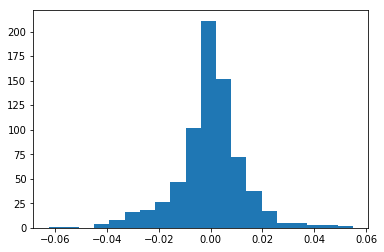

In [133]:
plt.hist(prices, bins=20)
plt.show()

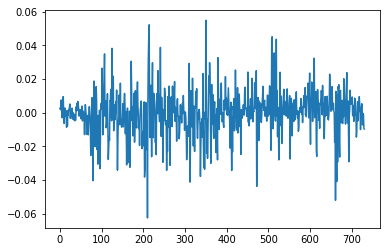

In [134]:
plt.plot(prices)

In [138]:
adfuller(prices)

(-8.535428772025405,
 1.0110438004829059e-13,
 6,
 724,
 {'1%': -3.4394144152232995,
  '5%': -2.8655403100177566,
  '10%': -2.5689002207655443},
 -4169.700082124158)